#### Creating a confusion matrix

##### 1. Parameters

In [1]:
import os
import yaml

config_1 = '/home/Thomas/ABC_expeditions_classifier/configs/ABC_experiment_2.yaml'
cfg_1 = yaml.safe_load(open(config_1, 'r'))

config_2 = '/home/Thomas/ABC_expeditions_classifier/configs/ABC_experiment_hierarchical_loss_8.yaml'
cfg_2 = yaml.safe_load(open(config_2, 'r'))

split = 'test' # options are "train", "test", and "none"
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

##### 2. Running the model

In [2]:
from ct_classifier.inference import model_inference

    # Baseline confusion matrix

df_summary_train_1  = model_inference(config=cfg_1, 
                                     checkpoint_path="/home/Thomas/ABC_expeditions_classifier/model_states/ABC_experiment_2/best.pt", 
                                     split = "train", 
                                     type = "summary")

df_summary_test_1  = model_inference(config=cfg_1, 
                                     checkpoint_path="/home/Thomas/ABC_expeditions_classifier/model_states/ABC_experiment_2/best.pt", 
                                     split = "test", 
                                     type = "summary")

    # Improvement confusion matrix

df_summary_train_2  = model_inference(config=cfg_2, 
                                     checkpoint_path="/home/Thomas/ABC_expeditions_classifier/model_states/ABC_experiment_hierarchical_loss_8/best.pt", 
                                     split = "train", 
                                     type = "summary")

df_summary_test_2  = model_inference(config=cfg_2, 
                                     checkpoint_path="/home/Thomas/ABC_expeditions_classifier/model_states/ABC_experiment_hierarchical_loss_8/best.pt", 
                                     split = "test", 
                                     type = "summary")

/home/Thomas/miniconda3/envs/ABC_expeditions_classifier/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/Thomas/miniconda3/envs/ABC_expeditions_classifier/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/Thomas/ABC_expeditions_classifier/ct_classifier/inference.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arb

##### 3. Fetching the data loader

In [3]:
import yaml
from ct_classifier.train import create_dataloader

    # Baseline model

dl_test_1 = create_dataloader(cfg = cfg_1, split=split)

    # Improved model

dl_test_2 = create_dataloader(cfg = cfg_2, split=split)


inverse_dict = dl_test_1.dataset.inv_labels

##### 3. Making a differential confusion matrix

Text(0.5, 1.0, 'Normalized Confusion Matrix (Reordered)')

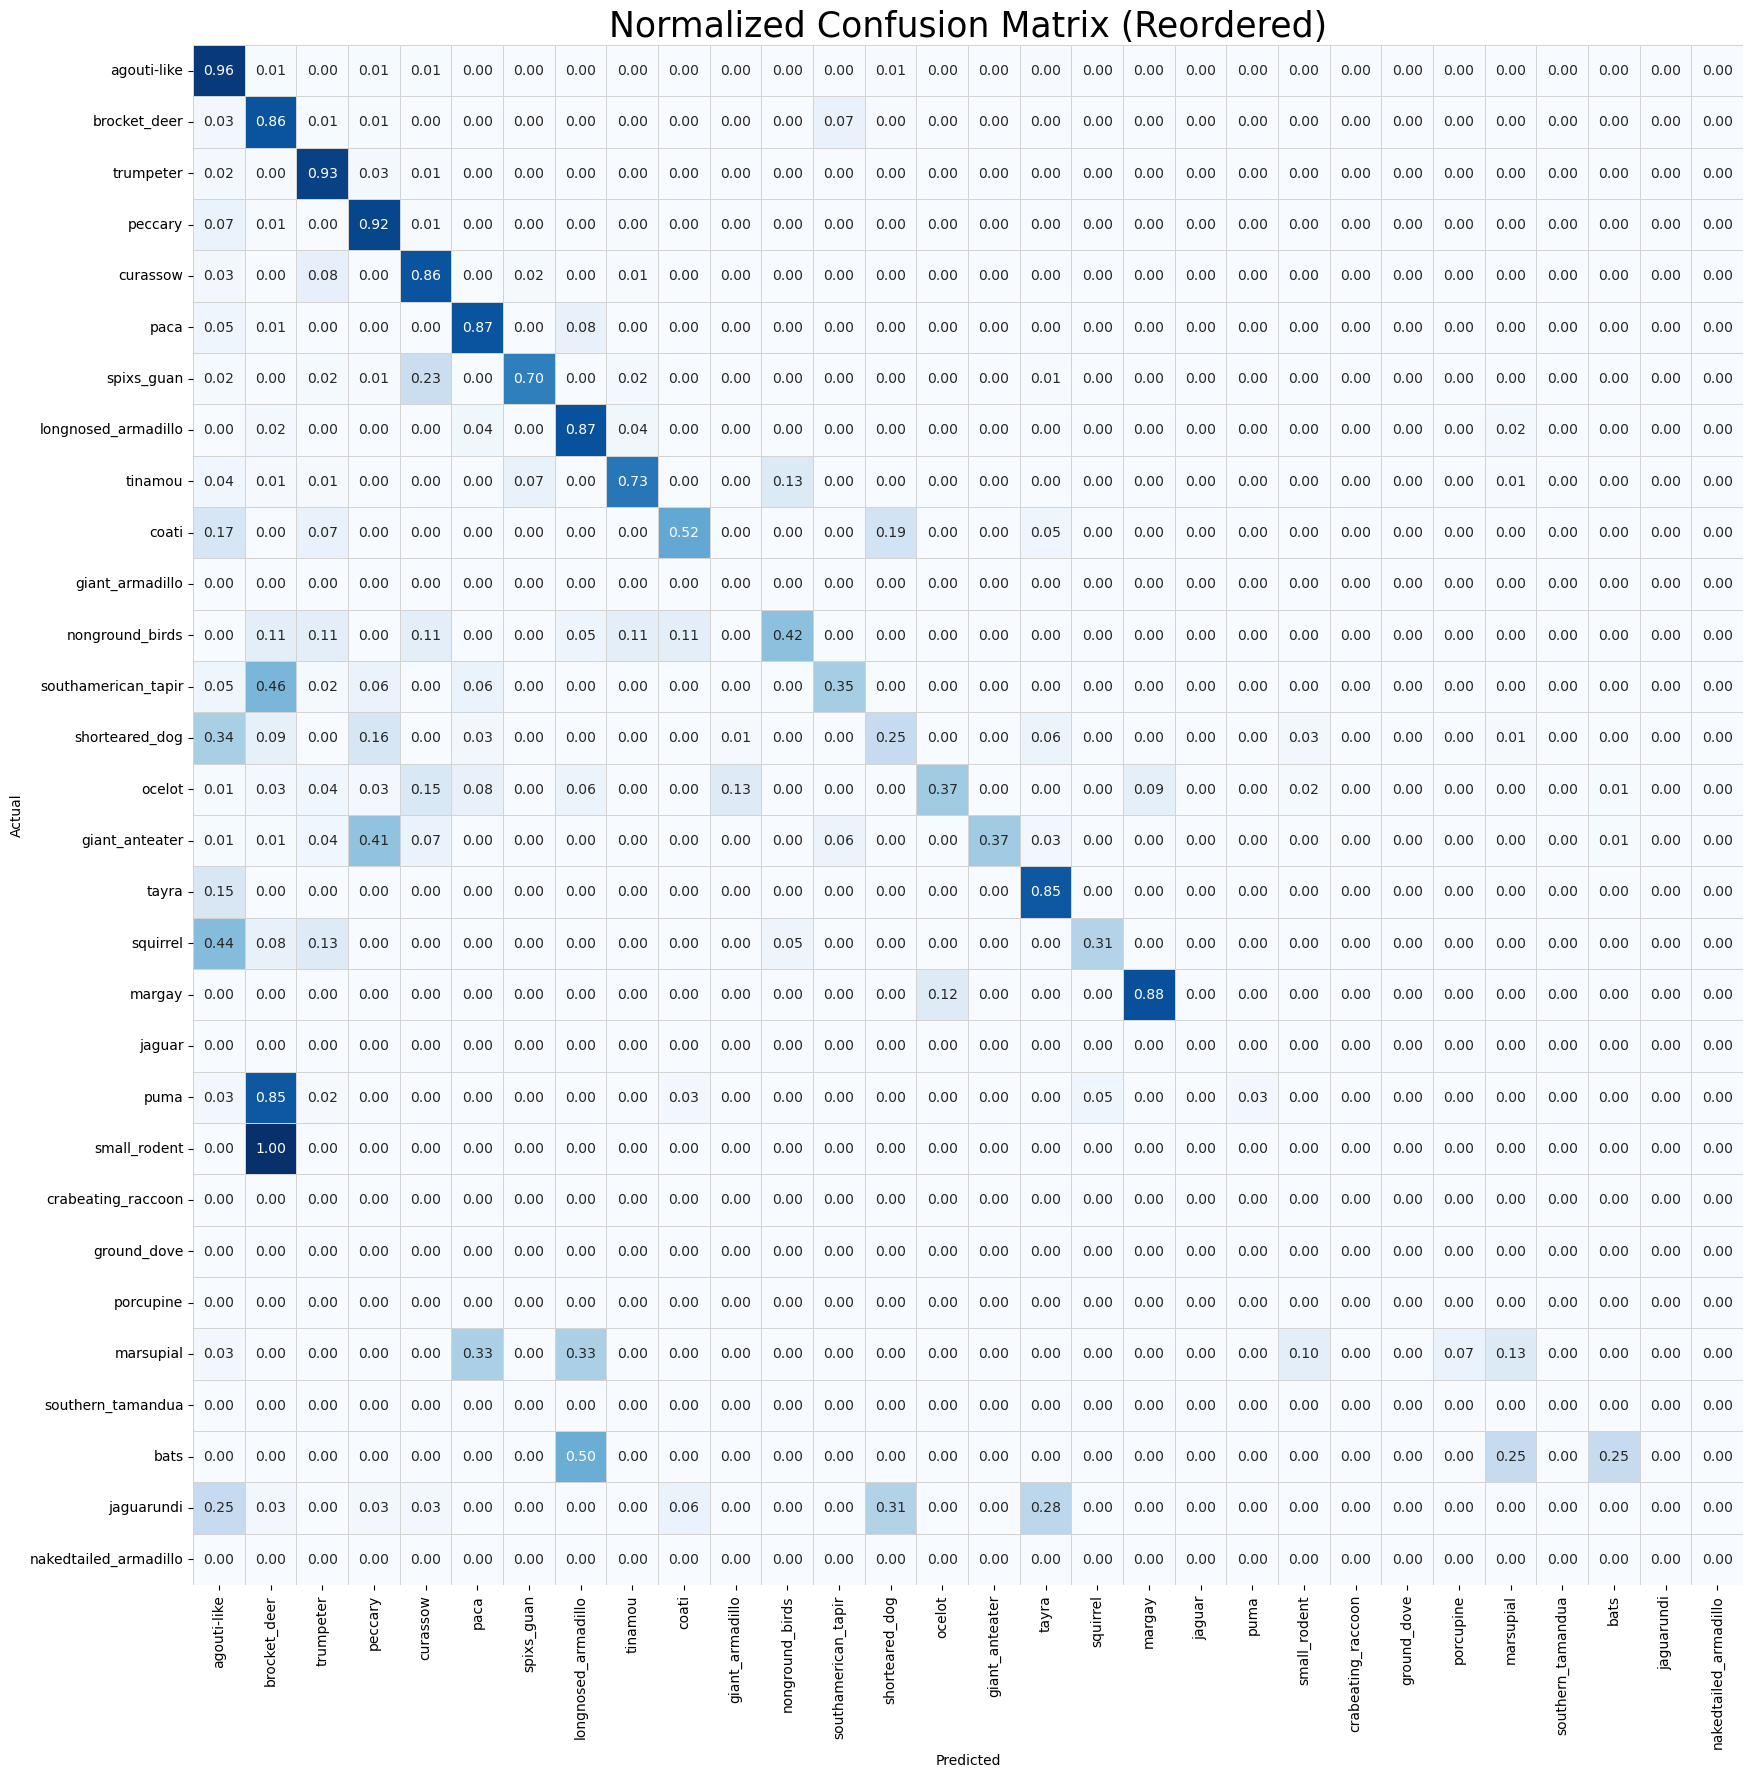

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

    # For the baseline model

true_labels_1 = df_summary_test_1["true_labels_full"].unique()
pred_labels_1 = df_summary_test_1["pred_labels_full"].unique()

labels_string_1 = [inverse_dict[x] for x in range(len(inverse_dict))]
order = df_summary_train_1["true_labels_full"].value_counts().reset_index()["true_labels_full"]

reorder_indices = [labels_string_1.index(label) for label in order if label in labels_string_1]

cm_1 = confusion_matrix(df_summary_test_1["true_labels_full"], 
                      df_summary_test_1["pred_labels_full"],
                      labels=labels_string_1, 
                      normalize = "true")

cm_reordered_1 = cm_1[np.ix_(reorder_indices, reorder_indices)]

labels_string_reordered_1 = [labels_string_1[i] for i in reorder_indices]

    # For the improvement model

true_labels_2 = df_summary_test_2["true_labels_full"].unique()
pred_labels_2 = df_summary_test_2["pred_labels_full"].unique()

labels_string_2 = [inverse_dict[x] for x in range(len(inverse_dict))]

reorder_indices = [labels_string_1.index(label) for label in order if label in labels_string_1]

cm_2 = confusion_matrix(df_summary_test_2["true_labels_full"], 
                      df_summary_test_2["pred_labels_full"],
                      labels=labels_string_2, 
                      normalize = "true")

cm_reordered_2 = cm_2[np.ix_(reorder_indices, reorder_indices)]

labels_string_reordered_2 = [labels_string_2[i] for i in reorder_indices]


    # Create the differential confusion matrix

cm_diff = cm_reordered_2 - cm_reordered_1

# Plot the reordered confusion matrix

vmax = np.abs(cm_diff).max()  # Maximum absolute value in the matrix
vmin = -vmax

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cm_reordered_2, 
            annot=True, 
            fmt='.2f', 
            cmap="Blues", 
            xticklabels=labels_string_reordered_1, 
            yticklabels=labels_string_reordered_2, 
            linecolor='lightgrey',  # Add thin grey lines
            linewidths=0.5,
            cbar=False)     # Set the width of the lines
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix (Reordered)', size=25)

# center=0,     # Center the colormap at 0
# vmin=vmin,    # Set color scale minimum
# vmax=vmax,